<div class="title">Implementing an SVC Model</div>
<div class="subtitle">Métodos Avanzados en Aprendizaje Automático</div>
<div class="author">Carlos María Alaíz Gudín &mdash; Universidad Autónoma de Madrid</div>

---
<div style="font-size: large; font-weight: bold; margin-left: 6em;"><p>Team Number and Names: <u>Pareja 10, Álvaro José Álvarez Arranz</u></div>


**Configuration**

This cell defines the general configuration of Jupyter Notebook.

In [ ]:
%%html
<head><link rel="stylesheet" href="style.css"></head>

This cell imports the packages to be used.

In [ ]:
# Standard packages.
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

# Custom packages.
from ml import (
	generate_dataset_moons,
	plot_dataset_clas,
	plot_svc,
)

# Initialisations.
matplotlib.rc("figure", figsize=(15, 5))
seed = 123

# Implementing an SVC Model

## Introduction

This practical assignment consists in implementing a simplified version of the SVC class of *scikit-learn*.

This class will contain two fundamentals routines, one for training a non-linear SVC (using the RBF kernel), based on the SMO algorithm for solving the dual optimization problem, and the other one for predicting over new out-of-sample points.

## SMO Algorithm

### Optimization Problem

The dual optimization problem for the Soft-Margin SVM is:
$$
 \left \{ \begin{array}{l} \min_{\boldsymbol{\alpha} \in \mathbb{R}^N} \frac{1}{2} \boldsymbol{\alpha}^\intercal \tilde{\mathbf{K}} \boldsymbol{\alpha} - \boldsymbol{\alpha}^\intercal \mathbf{1} \\ \text{ s.t. } \boldsymbol{\alpha}^\intercal \mathbf{y} = 0 , 0 \le \boldsymbol{\alpha} \le C ,
 \end{array} \right .
$$
where $\tilde{k}_{ij} = y_i y_j \mathcal{K}(\mathbf{x}_i, \mathbf{x}_j)$.

This optimization problem is a QP problem, which is usually solved using an *ad hoc* algorithm: Sequential Minimal Optimization (SMO).

### SMO and Coordinate Descent

The main idea behind SMO is that the optimization problem is too involved to be solved as a whole, but it can be largely simplified considering only a few variables at a time.
In this divide-and-conquer approach, called coordinate descent, the objective function is iteratively minimized over the different variables.

In particular, SMO deals with two variables, the smaller working group that can be modified while respecting the constraints.
Formally, the algorithm updates the current $\alpha^\text{old}_i$ and $\alpha^\text{old}_j$ coefficients to some new values $\alpha_i$ and $\alpha_j$, assuming that $\boldsymbol{\alpha}^\text{old}$ satisfies $(\boldsymbol{\alpha}^\text{old})^\intercal \mathbf{y} = 0$. In order to keep respecting the constraint in the new estimation, the following equation needs to be fulfilled:
\begin{align*}
 & y_i \alpha^\text{old}_i + y_j \alpha^\text{old}_j = y_i \alpha_i + y_j \alpha_j \\
 &\implies y_i (\alpha_i - \alpha^\text{old}_i) = - y_j (\alpha_j - \alpha^\text{old}_j) \\
 &\implies \alpha_i = \alpha^\text{old}_i - y_i y_j (\alpha_j - \alpha^\text{old}_j) .
\end{align*}

For simplicity, one can assume that the update for the $j$-th coefficient is given by $\alpha_j = \alpha^\text{old}_j + d$, and hence the optimization problem becomes a simple one-dimensional minimization.
Therefore, it can be solved by computing the derivative with respect to $d$ and equating to $0$.
After some derivations, the optimum unconstrained update turns out to be:
\begin{align*}
 d &= \frac{y_j (E(\mathbf{x}_j, y_j) - E(\mathbf{x}_i, y_i))}{\kappa} , \text{ where} \\
 \kappa &= 2 \mathcal{K}(\mathbf{x}_i, \mathbf{x}_j) - \mathcal{K}(\mathbf{x}_i, \mathbf{x}_i) - \mathcal{K}(\mathbf{x}_j, \mathbf{x}_j) , \text{ and} \\
 E(\mathbf{x}, y) &= \sum_{i = 1}^N \alpha^\text{old}_i y_i \mathcal{K}(\mathbf{x}_i, \mathbf{x}) - y .
\end{align*}

### Clipping

The previous update does not take into account the box constrains $0 \le \alpha_i, \alpha_j \le C$.
In order to satisfy these constraints for both $\alpha_i$ and $\alpha_j$, $\alpha_j$ has to be clipped to the interval $[L, H]$, where
$$
 \begin{cases}
  L = \max(0, \alpha^\text{old}_j - \alpha^\text{old}_i), & H = \min(C, C - \alpha^\text{old}_i + \alpha^\text{old}_j) & \text{if } y_i \neq y_j , \\
  L = \max(0, \alpha^\text{old}_j + \alpha^\text{old}_i - C), & H = \min(C, \alpha^\text{old}_i + \alpha^\text{old}_j) & \text{if } y_i = y_j .
 \end{cases}
$$

Therefore, the update for $\alpha_j$ becomes:
$$ \alpha_j = \min(\max(\alpha^\text{old}_j + d, L), H) , $$
and, as mentioned above, the corresponding update for $\alpha_i$ is:
$$ \alpha_i = \alpha^\text{old}_i - y_i y_j (\alpha_j - \alpha^\text{old}_j) . $$

### Selecting the Working Pair

There are different methods for selecting the working pair of coefficients $(i, j)$ that will be updated.
Usually, first or second order information is used to choose the working set, trying to find those that will provide the largest minimization of the objective function.

Nevertheless, in this work a simplified version of SMO will be implemented.
The first coefficient $i$ will be selected just iteratively, cycling over all the possible values $i = 1, 2, \dotsc, N$. The second coefficient $j$ is selected randomly over the remaining possible values $j \neq i$.

It should be noted that this approach will not guarantee the convergence in general, since not all possible pairs $(i, j)$ are explored, but it will work in most problems.

### Stopping Criteria

The algorithm will be terminated when a certain maximum number of iterations is reached (for each iteration, all the coefficients are updated), or when after one iteration the total change of the coefficients is smaller than a certain tolerance, $\| \boldsymbol{\alpha} - \boldsymbol{\alpha}^\text{old}\| < \epsilon$.

Since the working pair is generated randomly, it can happen that after a whole iteration the changes are smaller than $\epsilon$ not because the optimization is finished, but because of "bad luck". A workaround is to set $\epsilon = 0$ to force all the iterations.

### Computing the Intercept

Once the optimum dual coefficients $\boldsymbol{\alpha}^*$ have been estimated, the intercept $b^*$ can be computed knowing that any support vector $\mathbf{x}_k$ with $0 < \alpha^*_k < C$ satisfies:
$$ b^* = y_k - \sum_{i = 1}^N \alpha^*_i y_i \mathcal{K}(\mathbf{x}_i, \mathbf{x}_k) . $$

This equality is usually averaged over all the possible vectors $k$ satisfying $0 < \alpha^*_k < C$ for reasons of numerical stability.

### Prediction

Once the model is trained and the optimal parameters $\boldsymbol{\alpha}^*$ and $b^*$ are known, the score predicted over a new sample $\mathbf{x}$ is:
$$ f(\mathbf{x}) = \sum_{i = 1}^N \alpha^*_i y_i \mathcal{K}(\mathbf{x}_i, \mathbf{x}) + b^* . $$

Finally, the class is assigned with:
$$ \hat{y} = \operatorname{sign}(f(\mathbf{x})) . $$

## Implementation of the SVC Model

### Requirements

The objective of this assignment is to complete the class `MySVC` sketched below, which should contain at least the following methods.

---
```python
__init__(self, C=1.0, gamma="scale", tol=0.0001, max_iter=10000)
```
* This is the construction method for the class, with the following parameters:
    * `C`: Regularization parameter $C$ of the SVC.
    * `gamma`: Kernel parameter $\gamma$ of the RBF kernel.
    * `tol`: Tolerance for the stopping criterion $\epsilon$.
    * `max_iter`: Maximum number of iterations (in the sense of epochs; each iteration contains a pass through all the coefficients).
* This method should only store the parameters in fields of the class, to be used when needed.

---
```python
fit(self, x, y)
```
* This is the training method, with the following parameters:
    * `x`: Training data matrix $\mathbf{X} \in \mathbb{R}^{N \times d}$.
    * `y`: Vector of labels $\mathbf{y}$, with $y_i \in \{-1, +1\}$.
* This method should solve the dual optimization problem, storing the obtained coefficients and other useful information in fields of the class.

---
```python
decision_function(self, x)
```
* This is the method that computes the output of the SVC, with the following parameters:
    * `x`: Test data matrix $\mathbf{X}' \in \mathbb{R}^{N' \times d}$.
* This method should predict the output (the score) of the SVC, using the information stored in the fields of the class, and return it as a vector.

---
```python
predict(self, x)
```
* This is the method that computes the predicted class of the SVC, with the following parameters:
    * `x`: Test data matrix $\mathbf{X}' \in \mathbb{R}^{N' \times d}$.
* This method should predict the assigned class of the SVC, using the information stored in the fields of the class, and return it as a vector.

### Recommendations

Additional auxiliary methods can be defined to simplify the code.
Some suggestions are:

1. A method to compute the output of the SVC, with the current estimated parameters but without considering the intercept:
$$ \sum_{i = 1}^N \alpha_i y_i \mathcal{K}(\mathbf{x}_i, \mathbf{x}) . $$
1. A method to compute $E(\mathbf{x}, y)$.
1. A method to compute the lower and upper bounds $L$ and $H$ for the clipping of the update.
1. A method to estimate $b^*$.

### Implementation

<div class="qst">

* Complete the `MySVC` class below, satisfying the described requirements.

</div>

In [ ]:
################################################################################
# Insert code. Additional imports.
import numpy as np
from sklearn.metrics.pairwise import rbf_kernel, linear_kernel
################################################################################


class MySVC:
    """
    SVC with a simplified version of SMO.
    """

    def __init__(self, C=1.0, gamma="scale", tol=0.0001, max_iter=100, kernel='rbf'):
        ########################################################################
        # Insert code. Assignment of the hyper-parameters (complete).
        self.C = C
        self.gamma=gamma
        self.tol=tol
        self.max_iter=max_iter
        self.kernel=kernel

        ########################################################################

    def fit(self, x, y):
        # Constants.
        n_pat = x.shape[0]
        n_dim = x.shape[1]

        # Options for gamma (for compatibility with sklean).
        if self.gamma == "scale":
            self.gamma = 1.0 / (n_dim * x.var())
        if self.gamma == "auto":
            self.gamma = 1.0 / n_dim

        # Initialization of the dual coefficients (named "a" instead of "alpha" for simplicity).
        self.a = np.zeros(n_pat)

        ########################################################################
        # Insert code. Other initializations (complete).
        self.x = x
        self.y = y
        ########################################################################

        # Loop over the iterations.
        for it in range(self.max_iter):
            ####################################################################
            # Insert code. Initializations (complete).
            a_old = np.array(self.a, copy=True)
            ####################################################################

            # Loop over the coefficients.
            for i in range(0, n_pat):
                j = self.choose_j(i)
                ################################################################
                # Insert code. Update of the corresponding a[i] and a[j] values (complete).
                aj_old = self.a[j]

                d = y[j] * (self.E_function(j) - self.E_function(i)) / self.k_function(i, j)
                L, H = self.LH_bounds(i, j, condition=(y[i]==y[j]))
                self.a[j] = min(max(aj_old + d, L), H)
                self.a[i] += - y[i] * y[j] * (self.a[j] - aj_old)
                ################################################################

            ####################################################################
            # Insert code. Check of the stopping conditions (complete).
            if np.linalg.norm(self.a - a_old) < self.tol:
              break
            ####################################################################

        ########################################################################
        # Insert code. Storage of the obtained parameters and computation of the intercept (complete).
        self.sv_cond = np.where((self.a > 0) & (self.a < self.C))[0]
        self.support_vectors_ = self.x[self.sv_cond]
        self.b = self.b_intercept(self.sv_cond)
        self.coef_dual = self.y[self.sv_cond] * self.a[self.sv_cond]
        ########################################################################

        return self

    def decision_function(self, x):
        ########################################################################
        # Insert code. Computation of the decision function over x (complete).
        return self.output(x)+self.b
        ########################################################################

    def predict(self, x):
        ########################################################################
        # Insert code. Computation of the predicted class over x (complete).
        return np.sign(self.decision_function(x))
        ########################################################################

    def choose_j(self, i):
        v = np.arange(len(self.a))
        return np.random.choice(v[v != i])

    ############################################################################
    # Insert code. Auxiliary methods (complete if needed).
    def output(self, x):
        return (self.a * self.y) @ rbf_kernel(self.x, x, self.gamma)

    def E_function(self,i):
      return self.output(self.x[i].reshape(1,-1))[0] - self.y[i]

    def LH_bounds(self, i, j, condition):
      if condition:
        return max(0, self.a[j] + self.a[i] - self.C), min(self.C, self.a[i] + self.a[j])
      else:
        return max(0, self.a[j] - self.a[i]), min(self.C, self.C - self.a[i] + self.a[j])

    def k_function(self, i, j):
      k_ij = rbf_kernel(self.x[i].reshape(1,-1), self.x[j].reshape(1,-1), self.gamma)[0,0]
      k_ii = rbf_kernel(self.x[i].reshape(1,-1), self.x[i].reshape(1,-1), self.gamma)[0,0]
      k_jj = rbf_kernel(self.x[j].reshape(1,-1), self.x[j].reshape(1,-1), self.gamma)[0,0]
      return (2 * k_ij - k_ii - k_jj)

    def b_intercept(self,k):
      return np.mean(self.y[k] - self.output(self.x[k]))
    ############################################################################

### Comparative with *scikit-learn*

The following cell generates the *moons* dataset, dividing it into train and test splits, and depicting it.

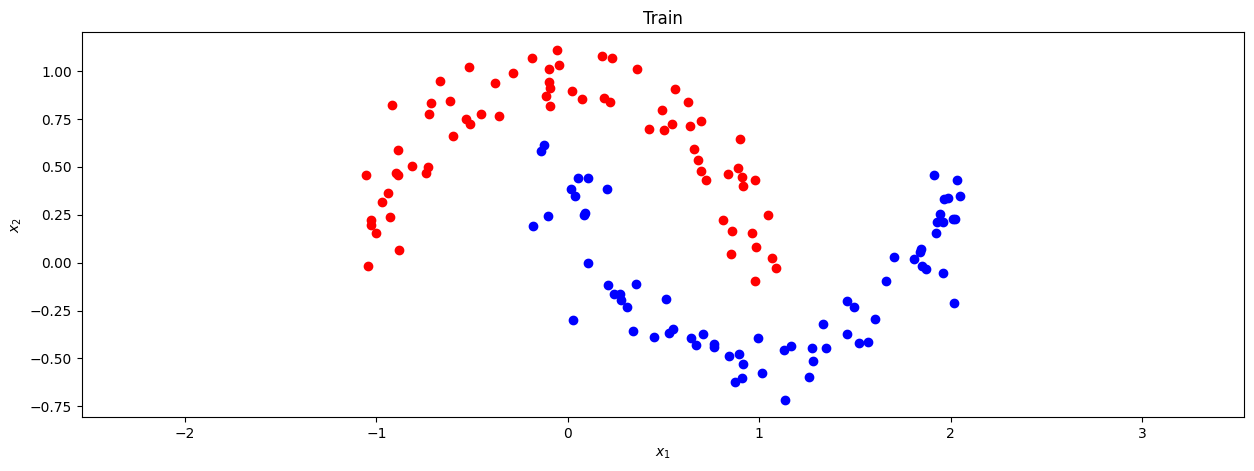

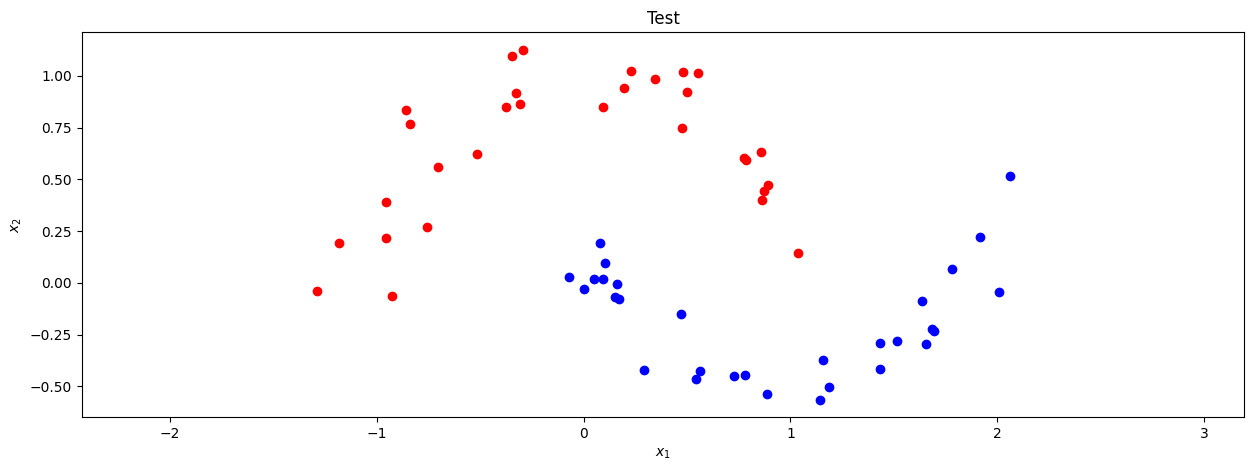

In [ ]:
x, y = generate_dataset_moons(seed)
x_tr, x_te, y_tr, y_te = train_test_split(x, y, test_size=0.3, random_state=seed)

plot_dataset_clas(x_tr, y_tr)
plt.title("Train")
plt.show()
plot_dataset_clas(x_te, y_te)
plt.title("Test")
plt.show()

<div class="qst">

* Train an SVC model over the training data (`x_tr`, `y_tr`), using both the `SVC` class of *scikit-learn* and the implemented `MySVC` class.
* Predict using the previous two models over the test data (`x_te`, `y_te`).
* Compare that both classes provide the same outputs (in terms of the decision function and of the predicted class), describing the obtained results.
  If needed, reduce the default stopping tolerance and/or increase the default maximum number of iterations.

</div>

In [ ]:
C = 1
gamma = "scale"
tol = 0.0001

model_my = MySVC(C=C, gamma=gamma, tol=tol)
model_sk = SVC(C=C, gamma=gamma, tol=tol)

################################################################################
# Insert code.
# Training of the models.
model_my.fit(x_tr,y_tr)
model_sk.fit(x_tr,y_tr)

# Scores of the two models.
scoreMySVC = model_my.decision_function(x_te)
scoreSklearnSVC = model_sk.decision_function(x_te)

# Prediction classes of the two models.
predictionMySVC = model_my.predict(x_te)
predictionSklearnSVC = model_sk.predict(x_te)
################################################################################

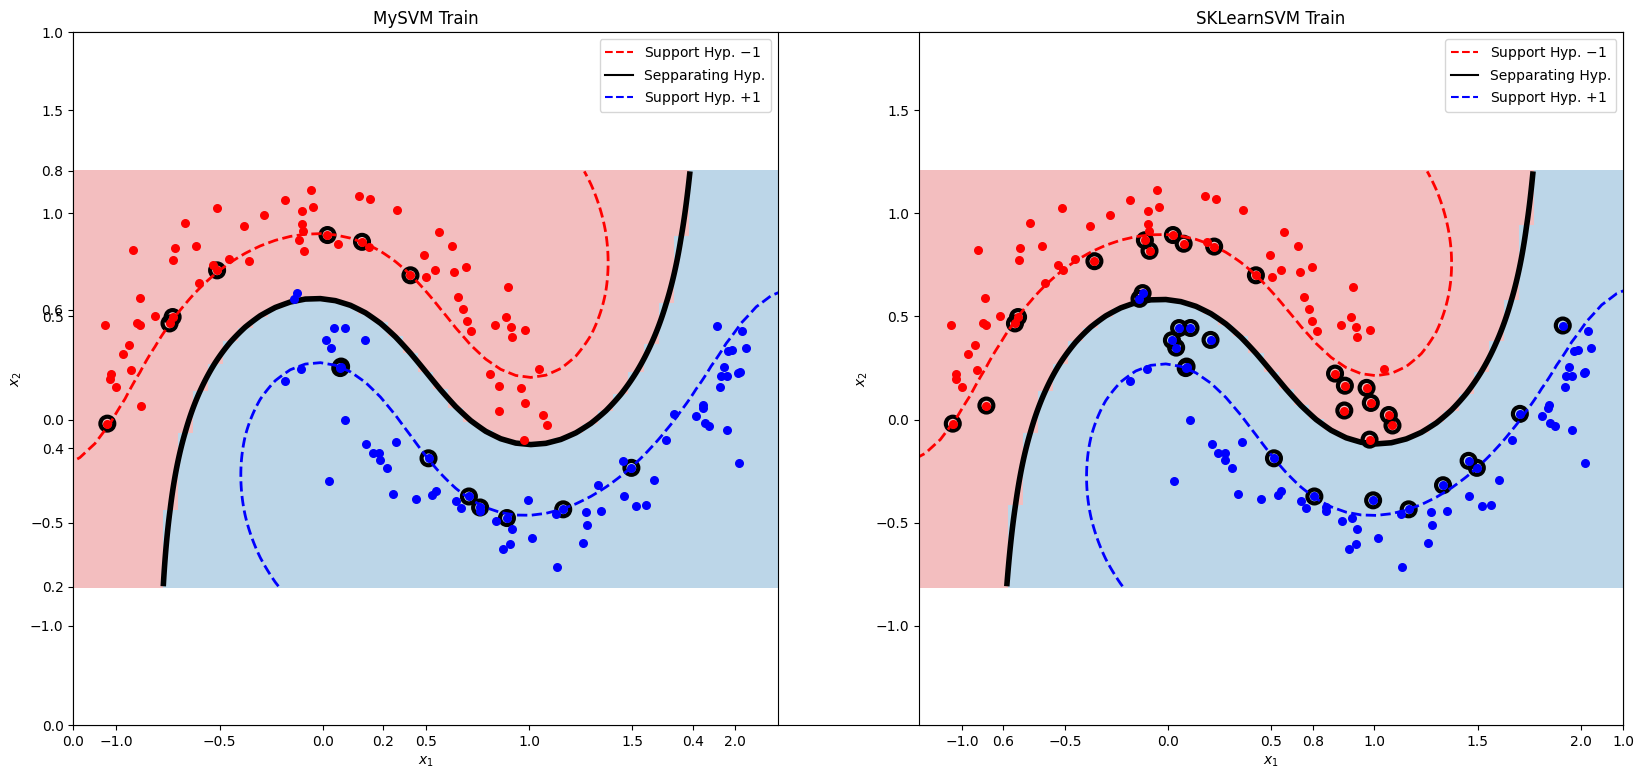

In [ ]:
plt.subplots(figsize=(20,9))

plt.subplot(121)
plot_svc(x_tr, y_tr, model_my)
plt.title("MySVM Train")

plt.subplot(122)
plot_svc(x_tr, y_tr, model_sk)
plt.title("SKLearnSVM Train")

plt.show()

Aunque la separación de clases por el hiperplano parece idéntica, podemos observar que hay algunas discrepancias. Para ello, se puede calcular el Error Medio Absoluto $\left(\text{MAE}\right)$, de las diferencias entre ambas soluciones.

En este cálculo no importa el grado de diferenciación entre los elementos, ya que ponderan de manera uniforme. También se podría utilizar Error Cuadrático Medio $\left(\text{MSE}\right)$ para realizar la comparación, ya que acentúa los errores más grandes y disminuye la importancia de los errores más pequeños.

Para esta operación `np.where(scoreMySVC != scoreSklearnSVC)` devuelve una tupla con el array y un elemento vacio, interesándonos unicamente el array filtrado.

In [ ]:
print("Cantidad elementos distintos =",len(np.where(scoreMySVC!=scoreSklearnSVC)[0]))
print("Elementos totales=",len(scoreMySVC))

print("MAE =",np.mean(np.abs(scoreMySVC-scoreSklearnSVC)))
print("MSE =",np.mean((scoreMySVC-scoreSklearnSVC)**2))

Cantidad elementos distintos = 60
Elementos totales= 60
MAE = 0.013795728096965991
MSE = 0.00027877113959054716


Podemos observar que los resultados obtenidos de ambas funciones de decisión son distintos, pero con una diferencia mínima como puede observarse en MAE y MSE.

### Predicciones

In [ ]:
np.array_equal(predictionMySVC, predictionSklearnSVC)

True

Podemos observar, con la línea de código anterior, que las predicciones generadas por ambos modelos son iguales.

Vamos a verificar la tasa de acierto y fallo de ambos modelos, que deberá ser idéntica debida a la línea de código anterior. Para ello usaremos `np.where(y_te==predictionMySVC)`, que devuelve un tupla con un array filtrado y un elemento vacio, interesándonos el array.


In [ ]:
# Tasa de acierto del modelo implementado
print("MySVC prediction: ")
print("  Test succes =", len(np.where(y_te==predictionMySVC)[0])/len(y_te))
print("  Test failure =", len(np.where(y_te!=predictionMySVC)[0])/len(y_te))

# Tasa de acierto del modelo sklearn
print("SklearnSVC prediction: ")
print("  Test succes =", len(np.where(y_te==predictionSklearnSVC)[0])/len(y_te))
print("  Test failure =", len(np.where(y_te!=predictionSklearnSVC)[0])/len(y_te))

MySVC prediction: 
  Test succes = 1.0
  Test failure = 0.0
SklearnSVC prediction: 
  Test succes = 1.0
  Test failure = 0.0


Podemos observar que ambos modelos tienen una tasa de acierto pleno con un $100\%$.

### Understanding the SVM

<div class="qst">

* Considering the model created with the `MySVC` class:
    * Extract the list of support vectors, explaining the followed approach.
    * Extract the list of training points bad and well classified, explaining the followed approach.
    * Extract the list of training points that lie over the supporting hyperplanes.
    * Extract the list of training points located on the wrong side of the supporting hyperplanes, but that are well classified.
* What are the conditions over the dual coefficients $\alpha_i$ that characterize the previous lists (if any)?

</div>

#### Extracción de los vectores soporte

In [ ]:
def show_support_vectors(x_tr, y_tr, x_te, y_te, C=1, gamma='scale', kernel='rbf', tol=0.0001):
    # Definición del modelo y entrenamiento
    model = MySVC(C=C, gamma=gamma, tol=tol, kernel=kernel)
    model.fit(x_tr, y_tr)

    # Mostrar los vectores de soporte
    print('Support vectors: \n{}'.format(model.support_vectors_))

    #Plot
    plot_svc(x_tr, y_tr, model)

Support vectors: 
[[ 0.96183352  0.1537731 ]
 [ 1.33244065 -0.31819234]
 [ 0.22290922  0.83884937]
 [ 1.12997481 -0.45602642]
 [ 0.42532529  0.69964593]
 [ 0.19045783  0.86185195]
 [-0.18288663  0.1890069 ]
 [ 1.94489372  0.25345182]
 [ 0.76296783 -0.42606162]
 [-1.04434178 -0.01958817]
 [ 0.08904053  0.25713775]
 [ 0.02300611  0.89485816]
 [-0.51219521  0.72357782]
 [-0.72779681  0.49724573]
 [ 0.08492022  0.24984896]
 [ 2.03392366  0.43176478]
 [ 1.49643186 -0.23391909]
 [ 0.07493939  0.85271149]
 [-0.74289036  0.46626099]
 [ 0.51282898 -0.18762429]
 [ 1.70496444  0.02775509]
 [ 1.16590578 -0.43503121]]


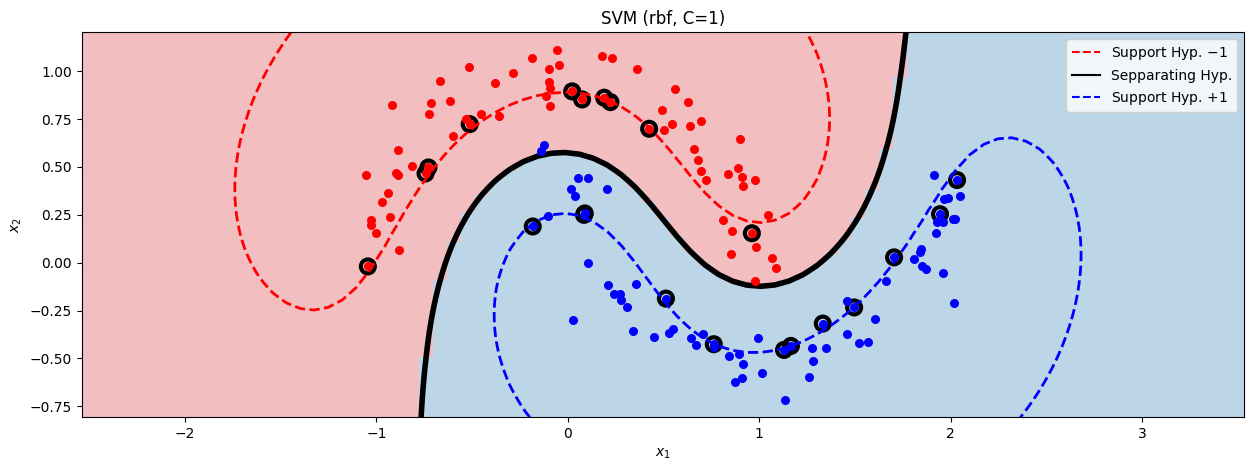

In [ ]:
################################################################################
# Insert code.
show_support_vectors(x_tr, y_tr, x_te, y_te)
################################################################################

Los vectores soporte son puntos de datos que se situan más cercanos al hiperplano, influyendo en la posición y orientación del mismo. Su función es maximizar el margen del clasificador. Para ello, los valores correspondientes de $\alpha$para cada dato deben estar en el intervalo $\left(0,\text{C}\right)$.

Por lo tanto, los puntos cuyos valores de $\alpha$ están en el rango, son considerados vectores soporte que están ubicados en el hiperplano. Este proceso se implementa en la función `fit()`, en el apartado de almacenamiento de parámetros.

Se puede mostrar una imagen del modelo que destaque exclusivamente los puntos que funcionan como vectores de soporte.

Support vectors =
 [[ 0.42532529  0.69964593]
 [ 0.19045783  0.86185195]
 [ 0.76296783 -0.42606162]
 [ 0.89315236 -0.4772365 ]
 [-1.04434178 -0.01958817]
 [ 0.08904053  0.25713775]
 [ 0.02300611  0.89485816]
 [-0.51219521  0.72357782]
 [-0.72779681  0.49724573]
 [ 0.08492022  0.24984896]
 [ 1.49643186 -0.23391909]
 [-0.74289036  0.46626099]
 [ 0.51282898 -0.18762429]
 [ 1.16590578 -0.43503121]
 [ 0.70872844 -0.3727295 ]]





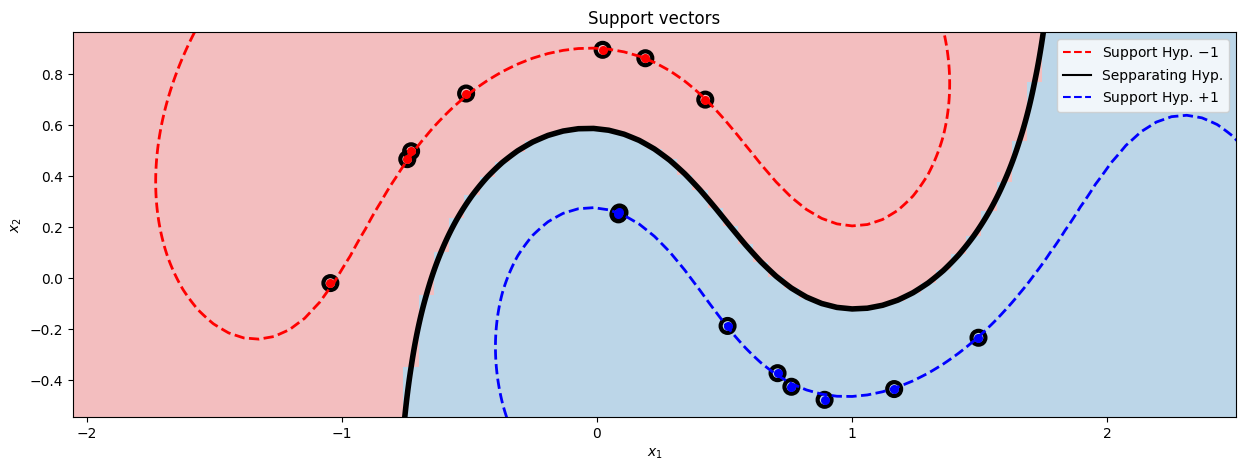

In [ ]:
print('Support vectors =\n', model_my.support_vectors_)

print("\n\n")
plot_svc(model_my.support_vectors_, y_tr[model_my.sv_cond], model_my)
plt.title("Support vectors")
plt.show()

#### Lista de los puntos bien y mal clasificados

Para realizar esto, se emplea la función `predict()` con los elementos de entrenamiento y comparando los resultados con los valores esperados. Luego, Clasificamos los elementos correctamente e incorrectamente para calcular la proporción de cada uno respecto al total de datos de entrenamiento.

Para ello vamos a mostrar el resultado de manera visual de los elementos tanto bien como mal clasificados.

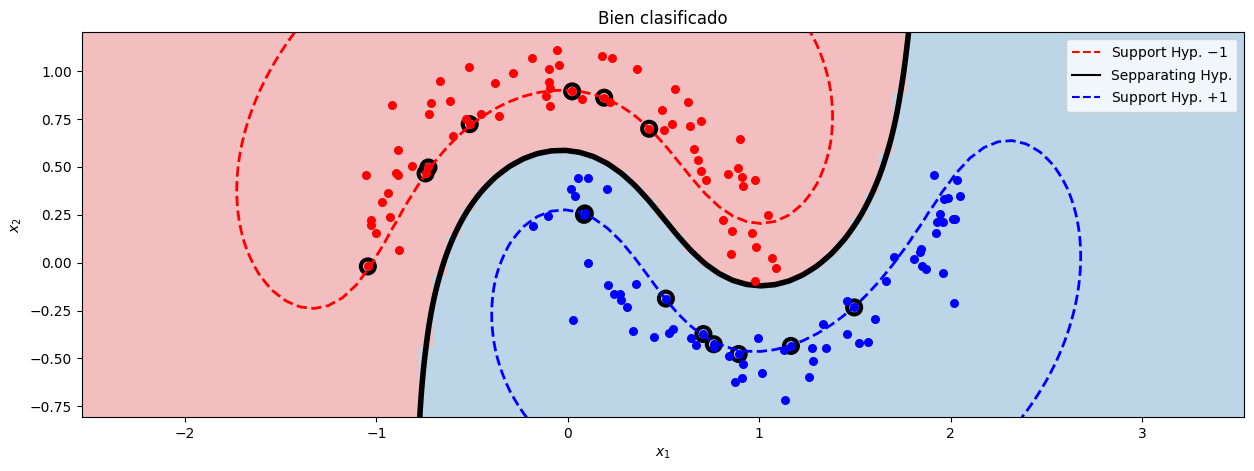

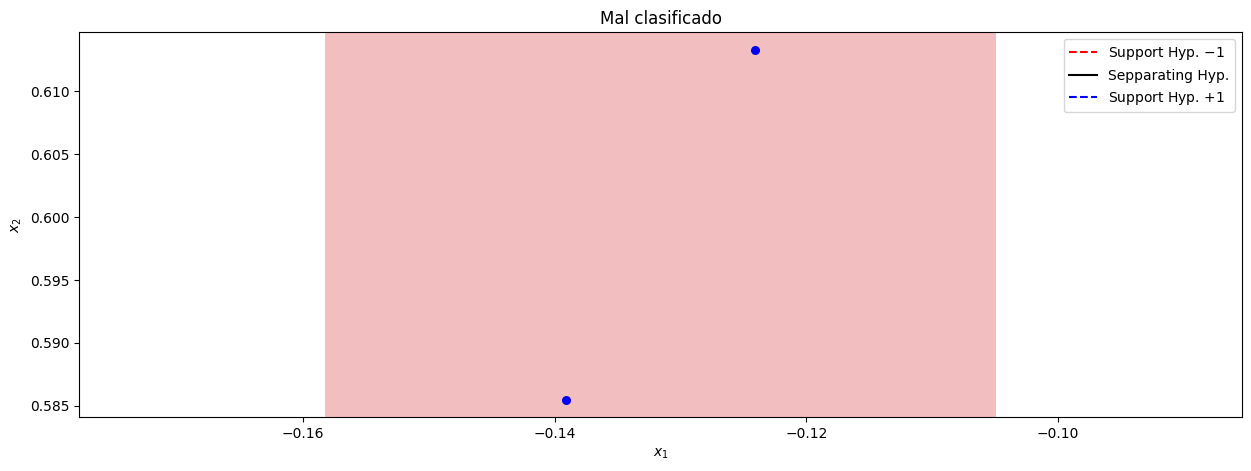

In [ ]:
predictEntr = model_my.predict(x=x_tr)

bienClas = np.where(y_tr==predictEntr)[0]

malClas = np.where(y_tr!=predictEntr)[0]

plot_svc(x_tr[bienClas], y_tr[bienClas], model_my)
plt.title("Bien clasificado")
plt.show()

print("\n\n")

#Cuando solo muestra un elemento el plot_svc() puede no funcionar correctamente
plot_svc(x_tr[malClas], y_tr[malClas], model_my)
plt.title("Mal clasificado")
plt.show()

#### Extraer los puntos de entrenamiento que se encuentran sobre los hiperplanos de soporte

Vamos a presentar de manera visual los puntos. Esto son los vectores soporte según las propiedades explicadas en la primera pregunta.

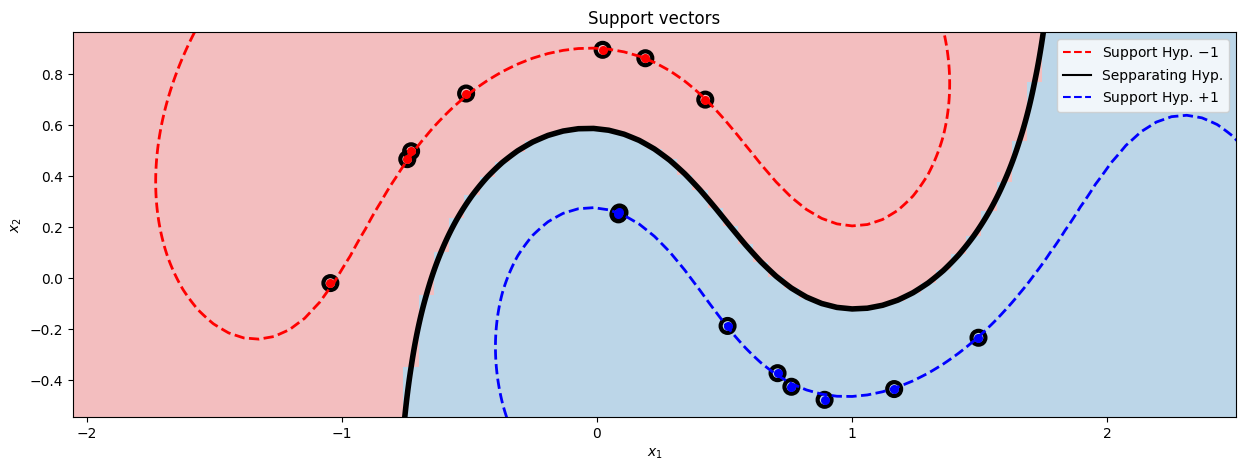

In [ ]:
plot_svc(model_my.support_vectors_, y_tr[model_my.sv_cond], model_my)
plt.title("Support vectors")
plt.show()

Se sabe teóricamente que una condición suficiente para que un vector $\textbf{x}_i$ se encuentre en uno de los hiperplanos soporte es $0<\alpha_i< C$. Esto es porque tendremos $y_i\left(\textbf{w}^T\Phi\left(\textbf{x}_i\right)+b\right)=1$. sin embargo, puede haber vectores de soporte con $\alpha_i=C$ que se encuentra sobre los hiperplanos soporte, porque esta condición implica que se cumpla la siguiente desigualdad:
$$
  y_i\left(\textbf{w}^T\Phi\left(\textbf{x}_i\right)+b\right)\le 1
$$

Incluso podría haber vectores que no son soporte con $\alpha_i=0$ que se encuentran sobre los hiperplanos soporte, ya que verifican $y_i\left(\textbf{w}^T\Phi\left(\textbf{x}_i\right)+b\right)\ge 1$.

Por eso no podemos confiar solo en los valores de $\alpha_i$ para identificar todos los puntos que se encuentren en uno de los hiperplanos soporte. en general, sólo podemos extraer un subconjunto de los puntos que se encuentran sobre los hiperplanos soporte.

#### Lista de los puntos de entrenamiento que se encuentran en el lado equivocado de los hiperplanos soporte, pero están bien clasificados

Para encontrar los puntos que, a pesar de estar en el lado equivocado del hiperplano soporte, están bien clasificados, buscaremos los que tengan $\alpha_i=C$

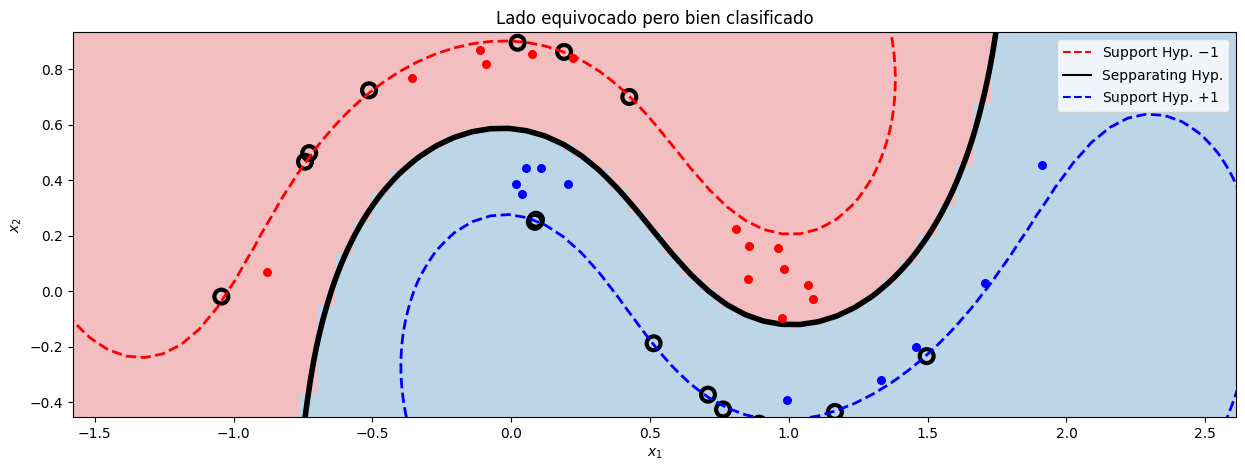

In [ ]:
filtradoC = np.where(model_my.a==C)[0]
elementsC = model_my.predict(x_tr[filtradoC])
bienClasC = filtradoC[np.where(elementsC==y_tr[filtradoC])[0]]

plot_svc(x_tr[bienClasC], y_tr[bienClasC], model_my)
plt.title("Lado equivocado pero bien clasificado")
plt.show()

Se puede observar que los puntos que están entre la línea punteada, que es hiperplano soporte, y la línea sólida, que es la separación de clases, están bien clasificados.

Esto ocurre por el valor de $C$. Con un valor bajo, el modelo es más flexible, permitiendo que algunos puntos estén en el "lado equivocado" mientras se están clasificando correctamente. Esto ayuda a bajar el sobreajuste, permitiendo que se generalice mejor.

#### Condiciones sobre los coeficientes $\alpha_i$ que caracterizan las listas anteriores

La condición que define las listas anteriores es $0\le\alpha\le C$. Con este criterio se puede deducir todo lo relacionado con los vectores soporte.